In [37]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing
%matplotlib inline

In [43]:
numdays = 365*10 + 2
base = '2010-01-01'
base = datetime.strptime(base, '%Y-%m-%d')
date_list = [base + timedelta(days=x) for x in range(numdays)]
date_list = np.array(date_list)
print(len(date_list), date_list[0], date_list[-1])

x = np.linspace(-np.pi, np.pi, 365)
orders_year = (np.sin(x) + 1.0) * 40
x = np.linspace(-np.pi, np.pi, 366)
orders_leap_year = (np.sin(x) + 1.0)
orders_s = []
for i in range(2010, 2020):
    if i == 2010:
        orders_s = orders_year + np.random.rand(365) * 40 + 35
    elif i in [2012, 2016]:
        orders_s = np.concatenate((orders_s, orders_leap_year * 40 + np.random.rand(366) * 40 + i % 2010 + 35))
    else:
        orders_s = np.concatenate((orders_s, orders_year + np.random.rand(365) * 40 + i % 2010 + 35))
print(len(orders_s))


# df
data = np.concatenate((date_list.reshape(-1, 1), orders_s.reshape(-1, 1)), axis=1)
df_orig = pd.DataFrame(data, columns=['date', 'orders'])
df_orig['date'] =  pd.to_datetime(df_orig['date'], format='%Y-%m-%d')
df = df_orig.set_index('date')
df.sort_index(inplace=True)
df['orders'] = df['orders'].astype(int)
# df
df.to_csv('orders.csv', index=False)

3652 2010-01-01 00:00:00 2019-12-31 00:00:00
3652


Text(0, 0.5, 'orders')

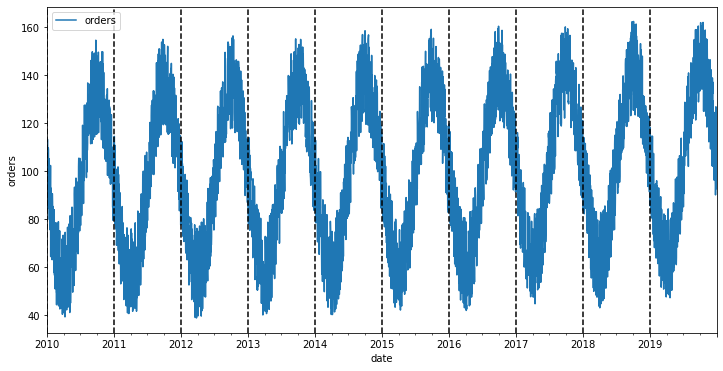

In [44]:
ax = df_orig.plot(x='date', y='orders', figsize=(12,6))
xcoords = ['2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
           '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
ax.set_ylabel('orders')

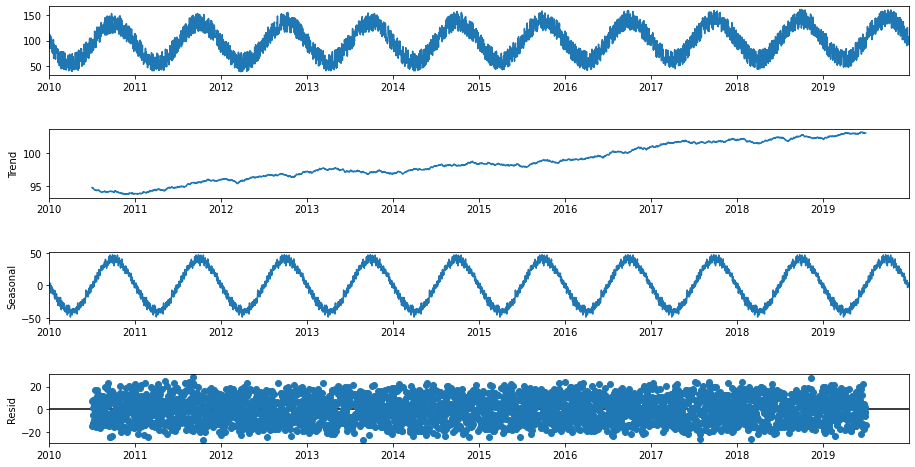

(date
 2010-01-01   NaN
 2010-01-02   NaN
 2010-01-03   NaN
 2010-01-04   NaN
 2010-01-05   NaN
               ..
 2019-12-27   NaN
 2019-12-28   NaN
 2019-12-29   NaN
 2019-12-30   NaN
 2019-12-31   NaN
 Name: trend, Length: 3652, dtype: float64, date
 2010-01-01    3.27600550
 2010-01-02   -1.83480119
 2010-01-03   -4.16417714
 2010-01-04   -3.72277684
 2010-01-05   -3.71942829
                  ...    
 2019-12-27   -3.48716040
 2019-12-28    3.72927796
 2019-12-29    2.72653823
 2019-12-30    3.27600550
 2019-12-31   -1.83480119
 Name: seasonal, Length: 3652, dtype: float64, date
 2010-01-01   NaN
 2010-01-02   NaN
 2010-01-03   NaN
 2010-01-04   NaN
 2010-01-05   NaN
               ..
 2019-12-27   NaN
 2019-12-28   NaN
 2019-12-29   NaN
 2019-12-30   NaN
 2019-12-31   NaN
 Name: resid, Length: 3652, dtype: float64)

In [45]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=365)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual
seasonal_decompose(df)

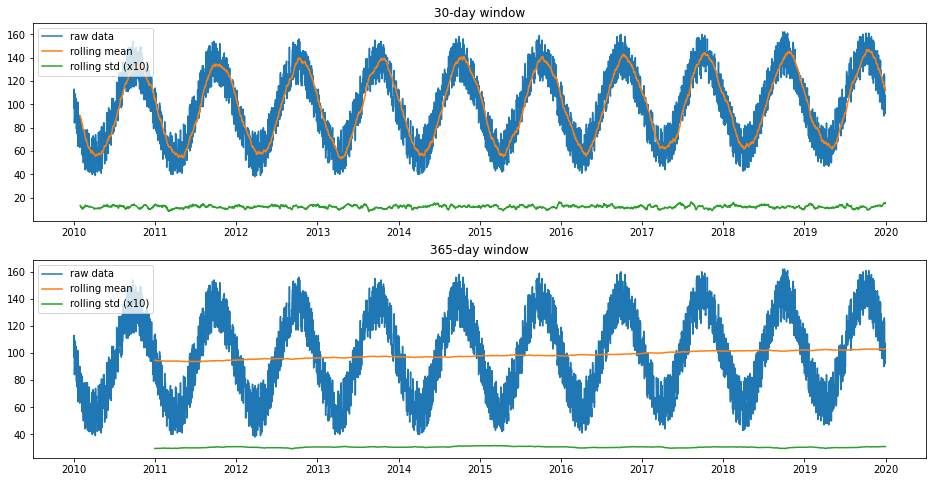

In [46]:
def analyze_stationarity(timeseries, title):
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))

    rolmean = pd.Series(timeseries).rolling(window=30).mean() 
    rolstd = pd.Series(timeseries).rolling(window=30).std()
    ax[0].plot(timeseries, label= title)
    ax[0].plot(rolmean, label='rolling mean');
    ax[0].plot(rolstd, label='rolling std (x10)');
    ax[0].set_title('30-day window')
    ax[0].legend()
    
    rolmean = pd.Series(timeseries).rolling(window=365).mean() 
    rolstd = pd.Series(timeseries).rolling(window=365).std()
    ax[1].plot(timeseries, label= title)
    ax[1].plot(rolmean, label='rolling mean');
    ax[1].plot(rolstd, label='rolling std (x10)');
    ax[1].set_title('365-day window')
    ax[1].legend()
pd.options.display.float_format = '{:.8f}'.format
analyze_stationarity(df['orders'], 'raw data')

In [47]:
y = df['orders'].astype(float)
y_to_train = y[:'2017-12-31']
y_to_val = y['2018-01-01':]
predict_date = len(y) - len(y[:'2017-12-31'])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


The Root Mean Squared Error of additive trend, additive seasonal of period season_length=365 and a Box-Cox transformation 12.98


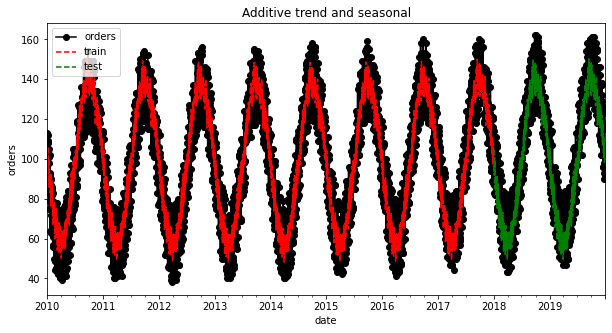

In [48]:
def holt_win_sea(y, y_to_train, y_to_test, seasonal_period, predict_date):
    
    fit1 = ExponentialSmoothing(y_to_train, seasonal_periods=seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
    fcast1 = fit1.forecast(predict_date).rename('Additive')
    mse1 = ((fcast1 - y_to_test.values) ** 2).mean()
    print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
          'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))

    y.plot(marker='o', color='black', legend=True, figsize=(10, 5))
    fit1.fittedvalues.plot(style='--', color='red', label='train')
    fcast1.plot(style='--', color='green', label='test')
    plt.ylabel('orders')
    plt.title('Additive trend and seasonal')
    plt.legend()
    plt.show()
    
holt_win_sea(y, y_to_train, y_to_val, 365, predict_date)